In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
# import mpld3
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
df = pd.read_csv('drive/MyDrive/perfect_dataset.csv')

In [ ]:
df.head()

,old_tag,title_x,artist_x,text,views,processed_artist,processed_title,tag,artist_y,title_y,processed title,artist_title
0,rock,Bring Me to Life,Evanescence,[Verse 1: Amy Lee]\nHow can you see into my ey...,658884,evanescence,bringmetolife,metal,Evanescence,Bring Me To Life,bringmetolife,evanescencebringmetolife
1,rock,My Immortal,Evanescence,[Verse 1]\nI'm so tired of being here\nSuppres...,392209,evanescence,myimmortal,metal,Evanescence,My Immortal,myimmortal,evanescencemyimmortal
2,rock,Zombie,Bad Wolves,[Verse 1]\nAnother head hangs lowly\nChild is ...,342157,badwolves,zombie,metal,Bad Wolves,Zombie,zombie,badwolveszombie
3,rock,A Little Piece of Heaven,Avenged Sevenfold,[Verse 1: M. Shadows]\nBefore the story begins...,259796,avengedsevenfold,alittlepieceofheaven,metal,Avenged Sevenfold,A Little Piece of Heaven,alittlepieceofheaven,avengedsevenfoldalittlepieceofheaven
4,rock,Doomsday,Architects,[Verse 1]\nRemember when Hell had frozen over?...,217795,architects,doomsday,metal,Architects,Doomsday,doomsday,architectsdoomsday


In [ ]:
df['tag'].value_counts()

tag
metal    35000
pop      35000
rap      35000
rb       35000
rock     35000
Name: count, dtype: int64

In [ ]:
df_tag = df[['text', 'tag']]
df_rap = df_tag[df_tag['tag']=='rap']
df_rock = df_tag[df_tag['tag']=='rock']
df_pop = df_tag[df_tag['tag']=='pop']
df_rb = df_tag[df_tag['tag']=='rb']
df_metal = df_tag[df_tag['tag']=='metal']
df_rock.head()

,text,tag
275,i want you to ask yourself one questionif you ...,rock
371,can we pretend that airplanesin the night sky ...,rock
501,"hype boys , hype boys , everyone ' s a killerd...",rock
541,"if you asked me what ' s on my mind , you prob...",rock
627,can we pretend that airplanesin the night sky ...,rock


In [ ]:
from sklearn.model_selection import train_test_split
df_train_all, df_test_all = train_test_split(df, test_size=0.8, random_state=42)

In [ ]:
df_tag = df[['text', 'tag']]
df_rap = df_tag[df_tag['tag']=='rap']
df_rock = df_tag[df_tag['tag']=='rock']
df_pop = df_tag[df_tag['tag']=='pop']
df_rb = df_tag[df_tag['tag']=='rb']
df_metal = df_tag[df_tag['tag']=='metal']

In [ ]:
df_train_rap, df_test_rap = train_test_split(df_rap, test_size=0.8, random_state=42)
df_train_metal, df_test_metal = train_test_split(df_metal, test_size=0.8, random_state=42)
df_train_rock, df_test_rock = train_test_split(df_rock, test_size=0.8, random_state=42)
df_train_pop, df_test_pop = train_test_split(df_pop, test_size=0.8, random_state=42)
df_train_rb, df_test_rb = train_test_split(df_rb, test_size=0.8, random_state=42)

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
from torch.nn import functional as F
model_name = 'roberta-base'

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        # self.l2 = torch.nn.Dropout(0.3)
        # self.l1 = torch.nn.Linear(768, 256)
        self.fc = torch.nn.Linear(768,5)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = F.softmax(self.fc(features), dim=1)
        return output


model = BERTClass()
model.load_state_dict(torch.load('drive/MyDrive/model4.bin', map_location=torch.device('cpu')))
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
MAX_LEN = 200
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = model.to(device)

In [ ]:
# from the model get only the features from the forward pass
def get_features(text):
    model.eval()
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)
    _, features = model.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
    return features.cpu().detach().numpy()

In [ ]:
# get features from datasets
df_train_rap['features'] = df_train_rap['text'].apply(get_features)
df_train_metal['features'] = df_train_metal['text'].apply(get_features)
df_train_rock['features'] = df_train_rock['text'].apply(get_features)
df_train_pop['features'] = df_train_pop['text'].apply(get_features)
df_train_rb['features'] = df_train_rb['text'].apply(get_features)
df_train_rap.head()

,text,tag,features
79824,"[Hook: Future]\nFuck up some commas, let's fuc...",rap,"[[0.20928983, -0.46988094, 0.68880147, -0.6236..."
72925,"[Intro]\nLord, please forgive me for what I do...",rap,"[[-0.56606734, 0.12982225, 0.5780556, -0.85726..."
80490,"[""Gezegen"" için şarkı sözleri]\n\n[Verse 1]\nD...",rap,"[[0.40283635, -0.8231268, 0.15625411, -0.15178..."
79637,[Verse 1: Jace]\nDeep down all I ever wanted w...,rap,"[[0.30475178, -0.35257617, 0.7128426, -0.54260..."
82444,"[Intro]\nSoulja hoe ass keep dissing Yatchy, h...",rap,"[[0.29100484, -0.3658753, 0.5587492, -0.538304..."


In [ ]:
# reshape to 1D arrays
df_train_rap.features = df_train_rap.features.apply(lambda x: x.reshape(-1))
df_train_metal.features = df_train_metal.features.apply(lambda x: x.reshape(-1))
df_train_rock.features = df_train_rock.features.apply(lambda x: x.reshape(-1))
df_train_pop.features = df_train_pop.features.apply(lambda x: x.reshape(-1))
df_train_rb.features = df_train_rb.features.apply(lambda x: x.reshape(-1))
df_train_rap.head()

,text,tag,features
79824,"[Hook: Future]\nFuck up some commas, let's fuc...",rap,"[0.20928983, -0.46988094, 0.68880147, -0.62363..."
72925,"[Intro]\nLord, please forgive me for what I do...",rap,"[-0.56606734, 0.12982225, 0.5780556, -0.857269..."
80490,"[""Gezegen"" için şarkı sözleri]\n\n[Verse 1]\nD...",rap,"[0.40283635, -0.8231268, 0.15625411, -0.151783..."
79637,[Verse 1: Jace]\nDeep down all I ever wanted w...,rap,"[0.30475178, -0.35257617, 0.7128426, -0.542603..."
82444,"[Intro]\nSoulja hoe ass keep dissing Yatchy, h...",rap,"[0.29100484, -0.3658753, 0.5587492, -0.5383048..."


In [ ]:
num_clusters = 3

# Метод к-средних - KMeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
km2 = KMeans(n_clusters=num_clusters)
km3 = KMeans(n_clusters=num_clusters)
km4 = KMeans(n_clusters=num_clusters)
km5 = KMeans(n_clusters=num_clusters)

km_rap = km.fit(df_train_rap['features'].to_list())
km_metal = km2.fit(df_train_metal['features'].to_list())
km_rock = km3.fit(df_train_rock['features'].to_list())
km_pop = km4.fit(df_train_pop['features'].to_list())
km_rb = km5.fit(df_train_rb['features'].to_list())

clusters_rap = km_rap.labels_.tolist()
clusters_metal = km_metal.labels_.tolist()
clusters_rock = km_rock.labels_.tolist()
clusters_pop = km_pop.labels_.tolist()
clusters_rb = km_rb.labels_.tolist()

clusters_rap[:10], clusters_metal[:10], clusters_rock[:10], clusters_pop[:10], clusters_rb[:10]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

([0, 1, 0, 0, 0, 0, 1, 0, 2, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 0, 1, 1, 1, 1, 1, 0, 0],
 [2, 0, 0, 0, 0, 2, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [ ]:
# use pca to reduce the dimensionality of the features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=2)
pca4 = PCA(n_components=2)
pca5 = PCA(n_components=2)

pca = pca.fit(df_train_rap['features'].to_list())
pca2 = pca2.fit(df_train_metal['features'].to_list())
pca3 = pca3.fit(df_train_rock['features'].to_list())
pca4 = pca4.fit(df_train_pop['features'].to_list())
pca5 = pca5.fit(df_train_rb['features'].to_list())

df_train_rap['pca'] = df_train_rap['features'].apply(lambda x: pca.transform([x])[0])
df_train_metal['pca'] = df_train_metal['features'].apply(lambda x: pca.transform([x])[0])
df_train_rock['pca'] = df_train_rock['features'].apply(lambda x: pca.transform([x])[0])
df_train_pop['pca'] = df_train_pop['features'].apply(lambda x: pca.transform([x])[0])
df_train_rb['pca'] = df_train_rb['features'].apply(lambda x: pca.transform([x])[0])
df_train_rap.head()

,text,tag,features,pca,pca_x,pca_y,cluster
79824,"[Hook: Future]\nFuck up some commas, let's fuc...",rap,"[0.20928983, -0.46988094, 0.68880147, -0.62363...","[-3.9489900234193995, -0.3807088325538735]",-3.948990,-0.380709,0
72925,"[Intro]\nLord, please forgive me for what I do...",rap,"[-0.56606734, 0.12982225, 0.5780556, -0.857269...","[8.03022100371193, -4.505020289834356]",8.030221,-4.505020,1
80490,"[""Gezegen"" için şarkı sözleri]\n\n[Verse 1]\nD...",rap,"[0.40283635, -0.8231268, 0.15625411, -0.151783...","[-1.9355740659486103, 4.231712376695483]",-1.935574,4.231712,0
79637,[Verse 1: Jace]\nDeep down all I ever wanted w...,rap,"[0.30475178, -0.35257617, 0.7128426, -0.542603...","[-4.115942990156221, 0.03757591301899758]",-4.115943,0.037576,0
82444,"[Intro]\nSoulja hoe ass keep dissing Yatchy, h...",rap,"[0.29100484, -0.3658753, 0.5587492, -0.5383048...","[-4.036305473089874, 0.03522778128368878]",-4.036305,0.035228,0


In [ ]:
df_train_rap[['pca_x', 'pca_y']] = df_train_rap['pca'].apply(pd.Series)
df_train_metal[['pca_x', 'pca_y']] = df_train_metal['pca'].apply(pd.Series)
df_train_rock[['pca_x', 'pca_y']] = df_train_rock['pca'].apply(pd.Series)
df_train_pop[['pca_x', 'pca_y']] = df_train_pop['pca'].apply(pd.Series)
df_train_rb[['pca_x', 'pca_y']] = df_train_rb['pca'].apply(pd.Series)
df_train_rap.head()

,text,tag,features,pca,pca_x,pca_y,cluster
79824,"[Hook: Future]\nFuck up some commas, let's fuc...",rap,"[0.20928983, -0.46988094, 0.68880147, -0.62363...","[-3.9489900234193995, -0.3807088325538735]",-3.948990,-0.380709,0
72925,"[Intro]\nLord, please forgive me for what I do...",rap,"[-0.56606734, 0.12982225, 0.5780556, -0.857269...","[8.03022100371193, -4.505020289834356]",8.030221,-4.505020,1
80490,"[""Gezegen"" için şarkı sözleri]\n\n[Verse 1]\nD...",rap,"[0.40283635, -0.8231268, 0.15625411, -0.151783...","[-1.9355740659486103, 4.231712376695483]",-1.935574,4.231712,0
79637,[Verse 1: Jace]\nDeep down all I ever wanted w...,rap,"[0.30475178, -0.35257617, 0.7128426, -0.542603...","[-4.115942990156221, 0.03757591301899758]",-4.115943,0.037576,0
82444,"[Intro]\nSoulja hoe ass keep dissing Yatchy, h...",rap,"[0.29100484, -0.3658753, 0.5587492, -0.5383048...","[-4.036305473089874, 0.03522778128368878]",-4.036305,0.035228,0


In [ ]:
df_train_rap['cluster'] = clusters_rap
df_train_metal['cluster'] = clusters_metal
df_train_rock['cluster'] = clusters_rock
df_train_pop['cluster'] = clusters_pop
df_train_rb['cluster'] = clusters_rb
df_train_rap.head()

,text,tag,features,pca,pca_x,pca_y,cluster
79824,"[Hook: Future]\nFuck up some commas, let's fuc...",rap,"[0.20928983, -0.46988094, 0.68880147, -0.62363...","[-3.9489900234193995, -0.3807088325538735]",-3.948990,-0.380709,0
72925,"[Intro]\nLord, please forgive me for what I do...",rap,"[-0.56606734, 0.12982225, 0.5780556, -0.857269...","[8.03022100371193, -4.505020289834356]",8.030221,-4.505020,1
80490,"[""Gezegen"" için şarkı sözleri]\n\n[Verse 1]\nD...",rap,"[0.40283635, -0.8231268, 0.15625411, -0.151783...","[-1.9355740659486103, 4.231712376695483]",-1.935574,4.231712,0
79637,[Verse 1: Jace]\nDeep down all I ever wanted w...,rap,"[0.30475178, -0.35257617, 0.7128426, -0.542603...","[-4.115942990156221, 0.03757591301899758]",-4.115943,0.037576,0
82444,"[Intro]\nSoulja hoe ass keep dissing Yatchy, h...",rap,"[0.29100484, -0.3658753, 0.5587492, -0.5383048...","[-4.036305473089874, 0.03522778128368878]",-4.036305,0.035228,0


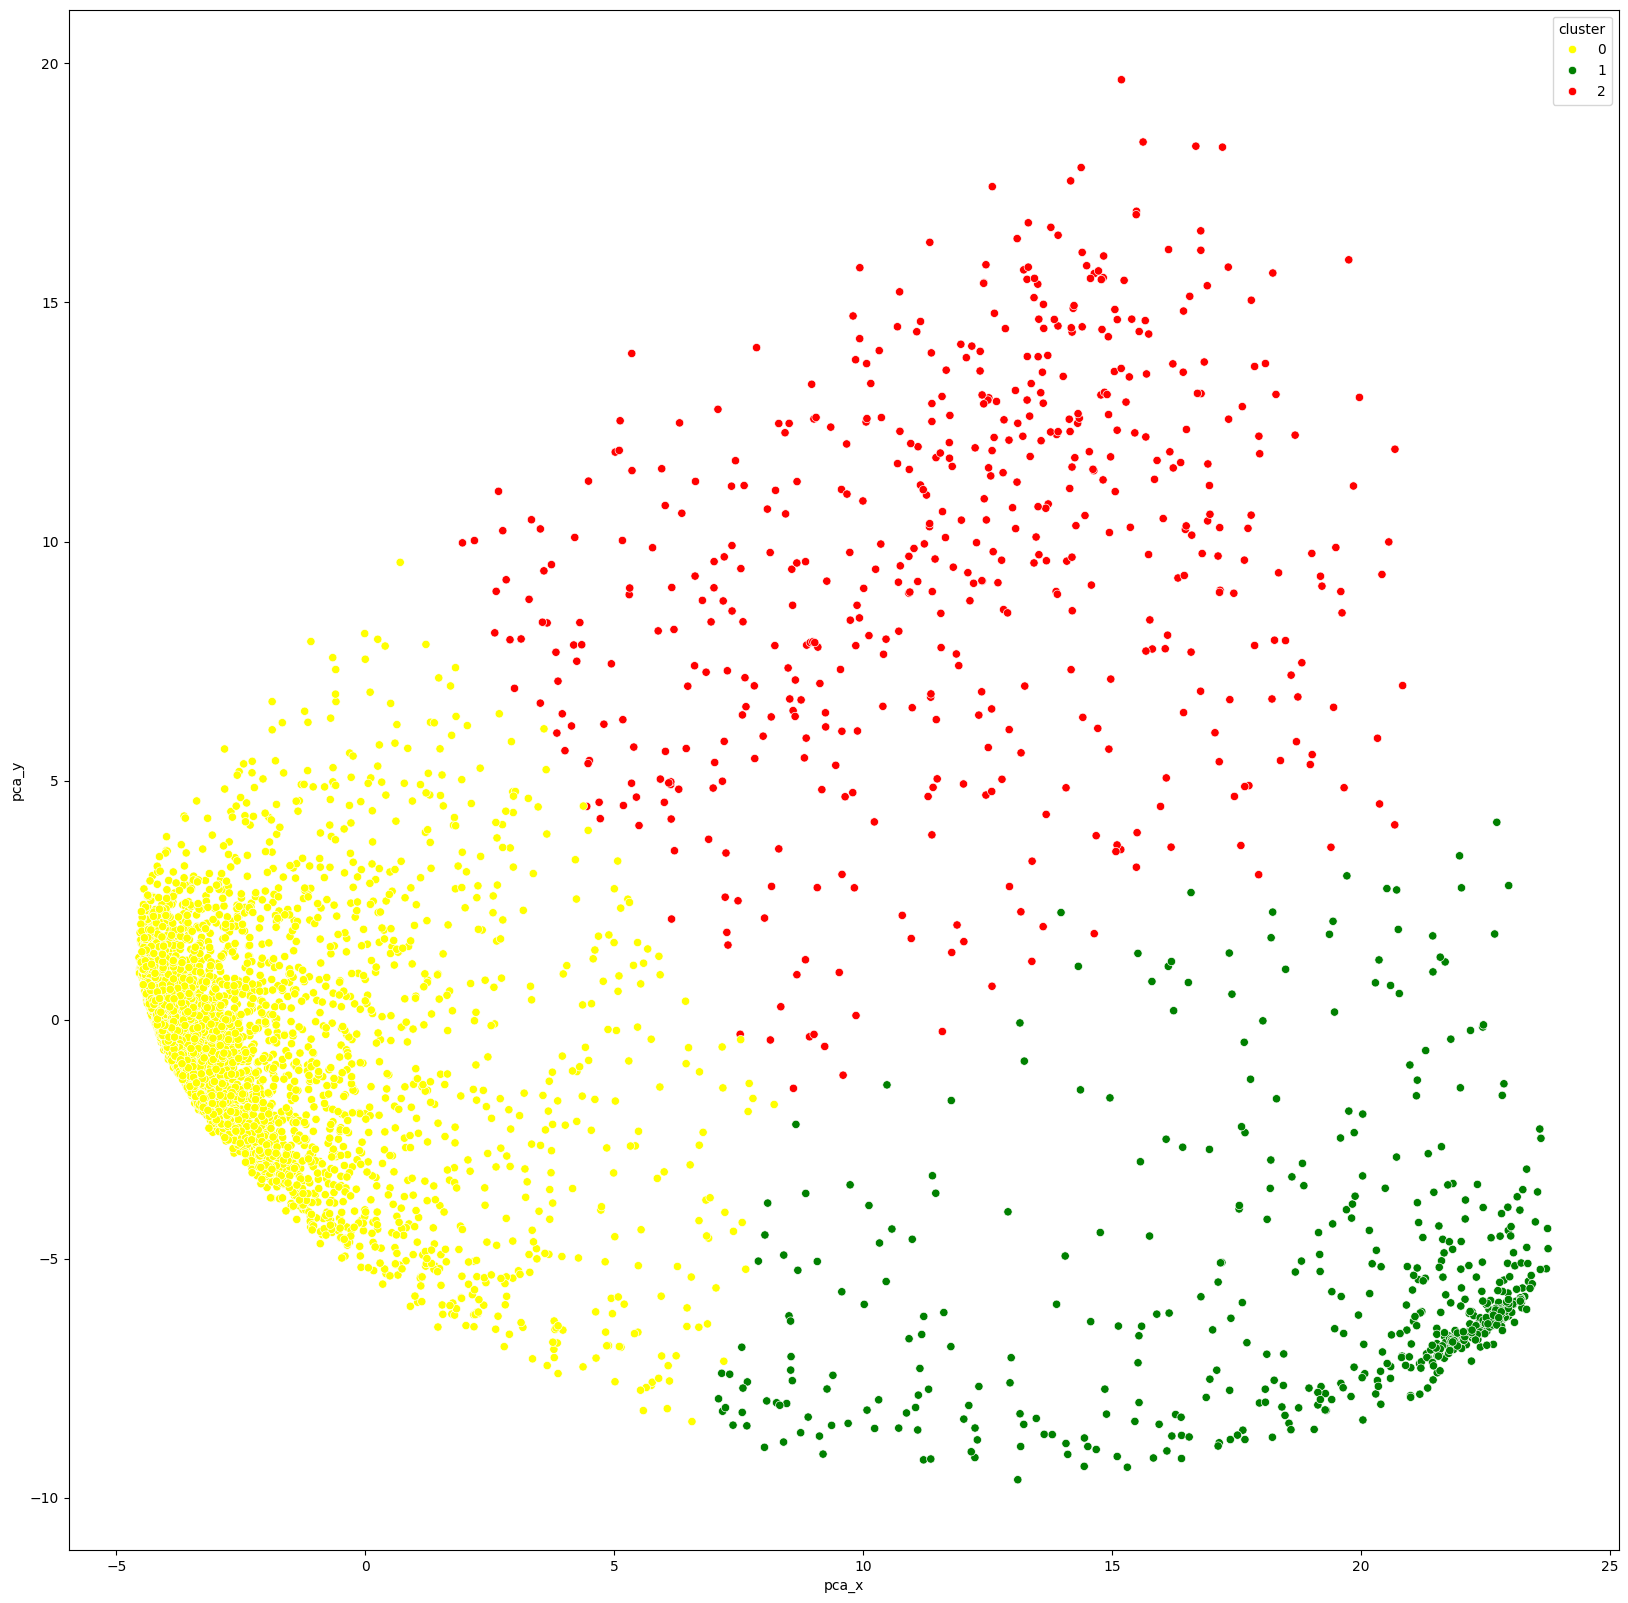

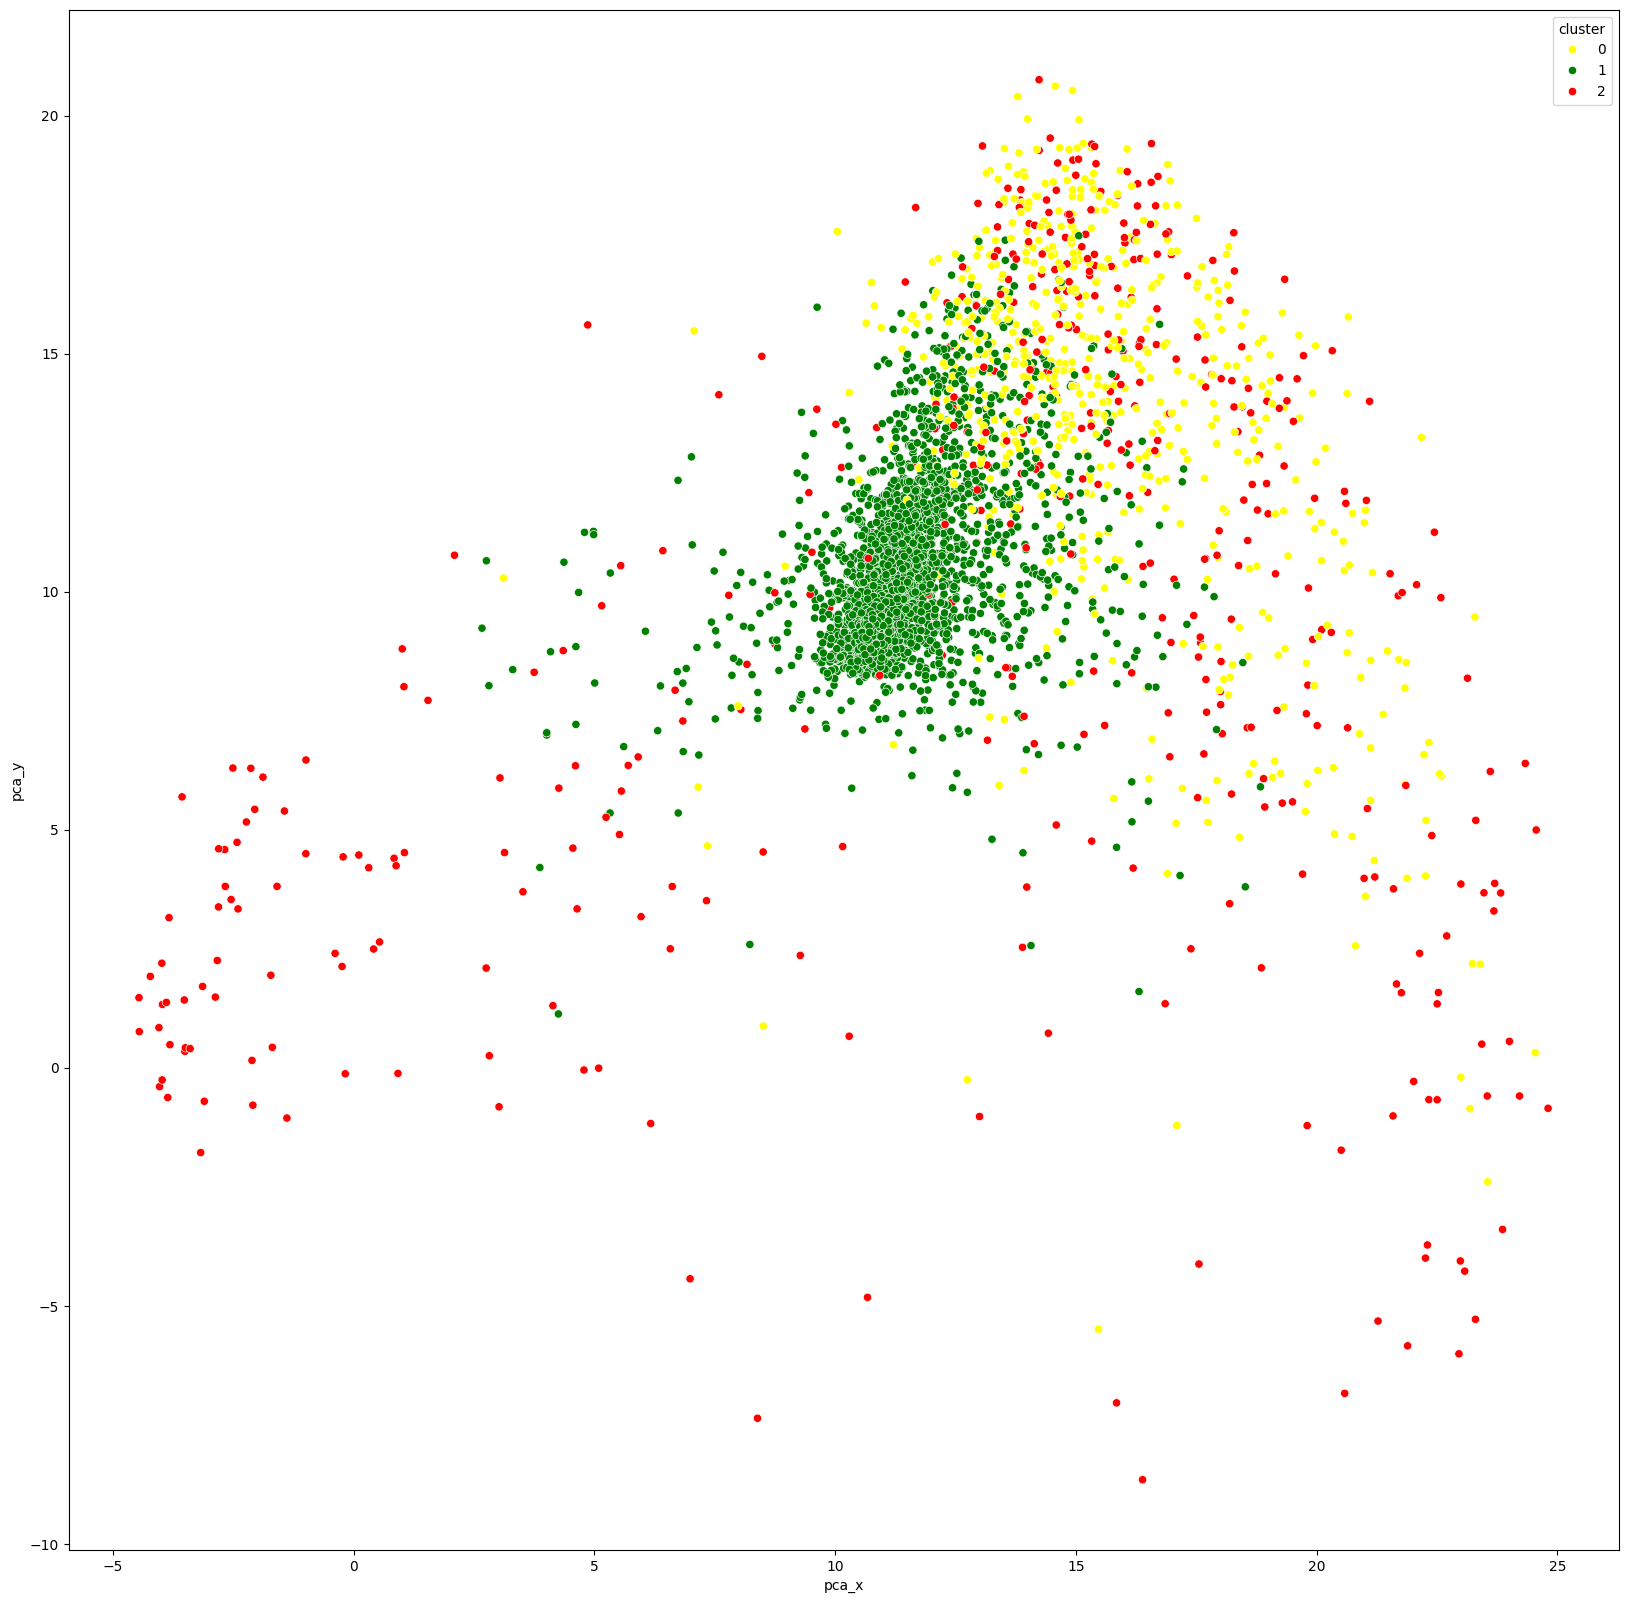

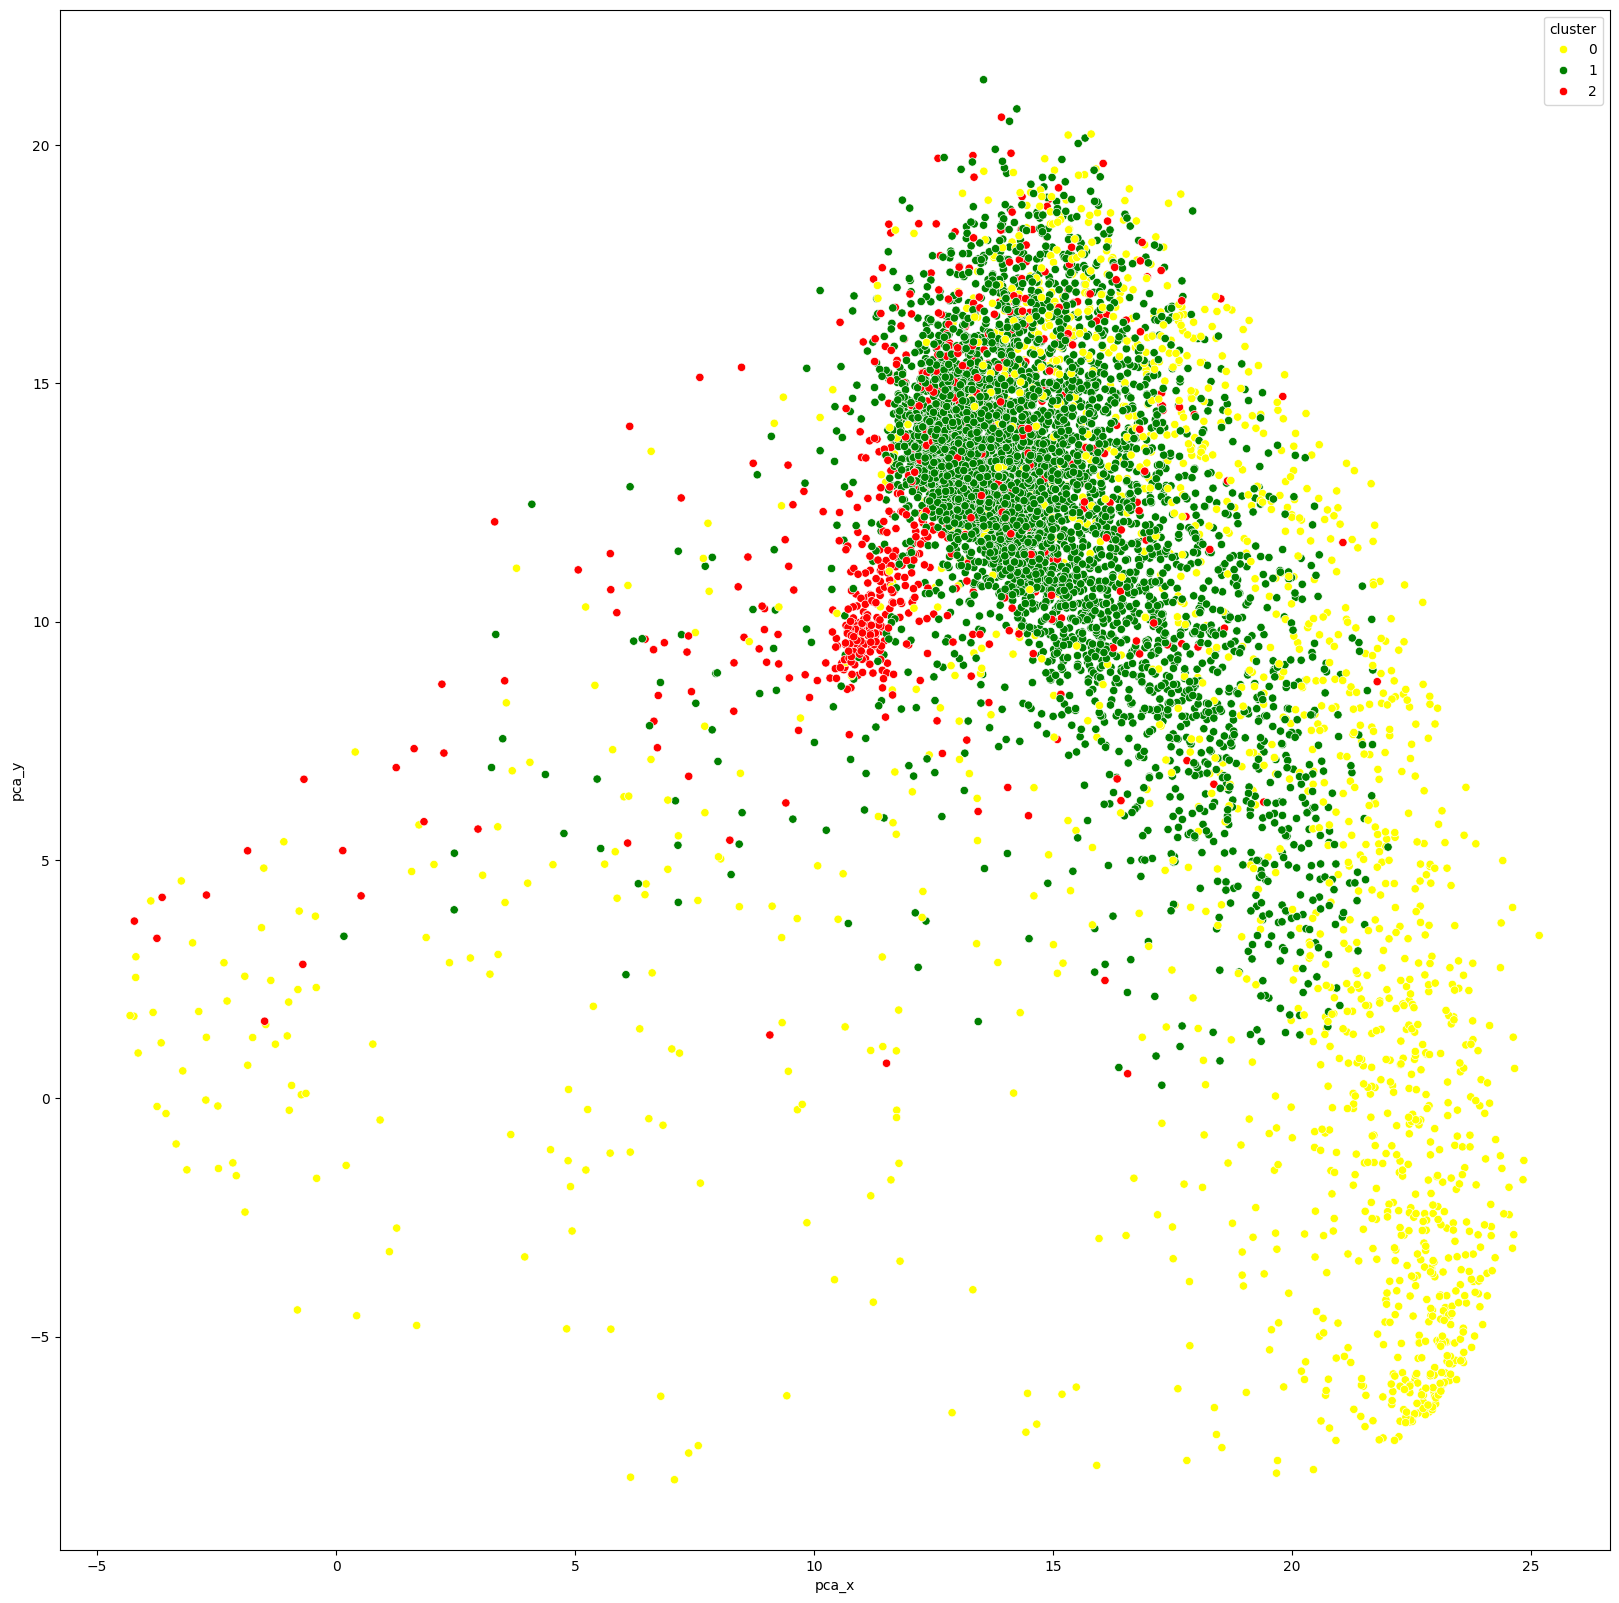

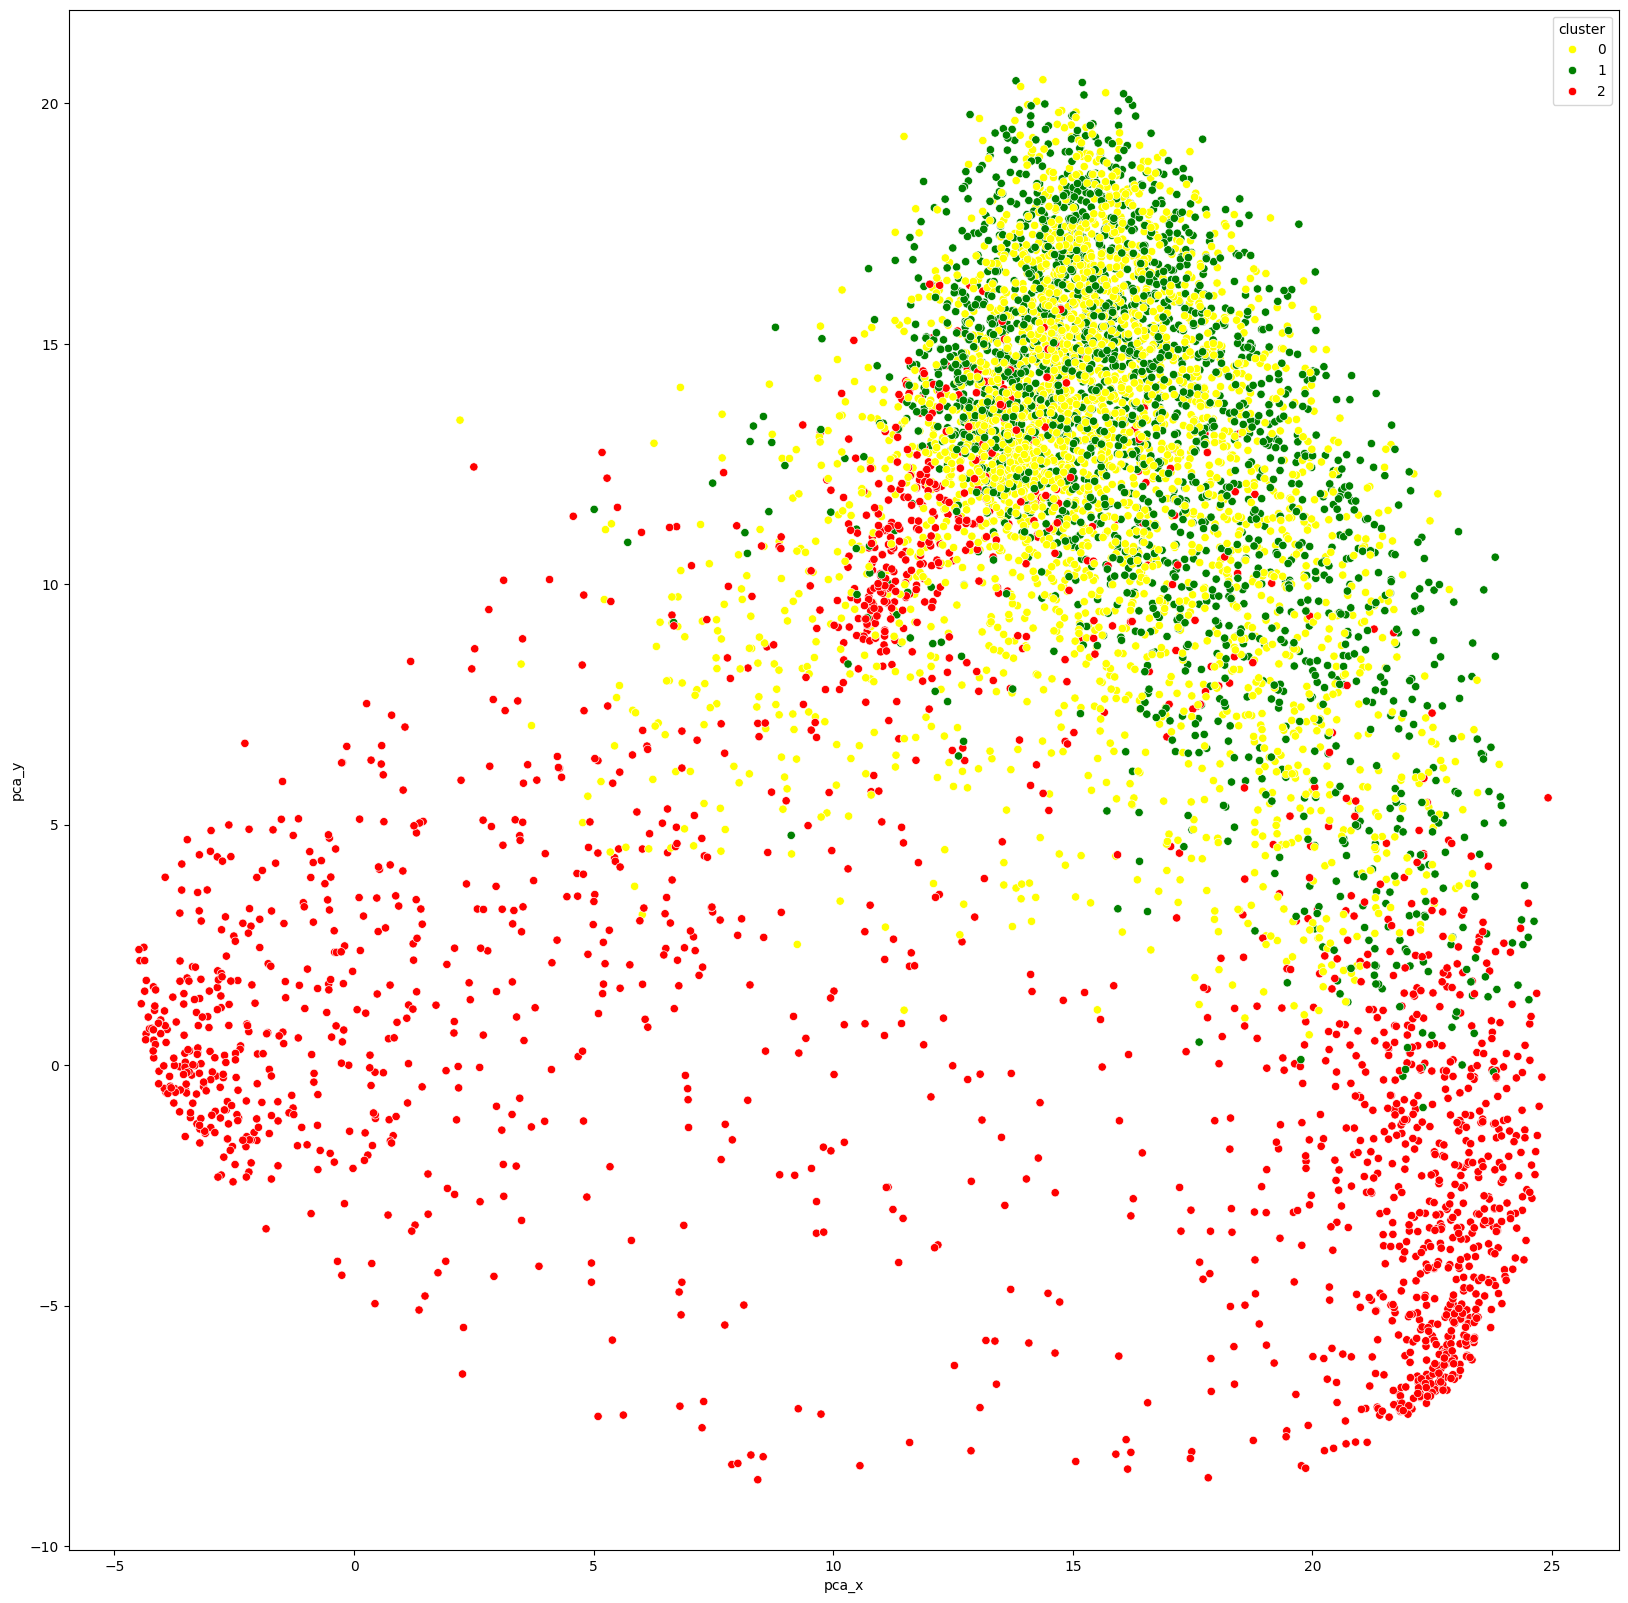

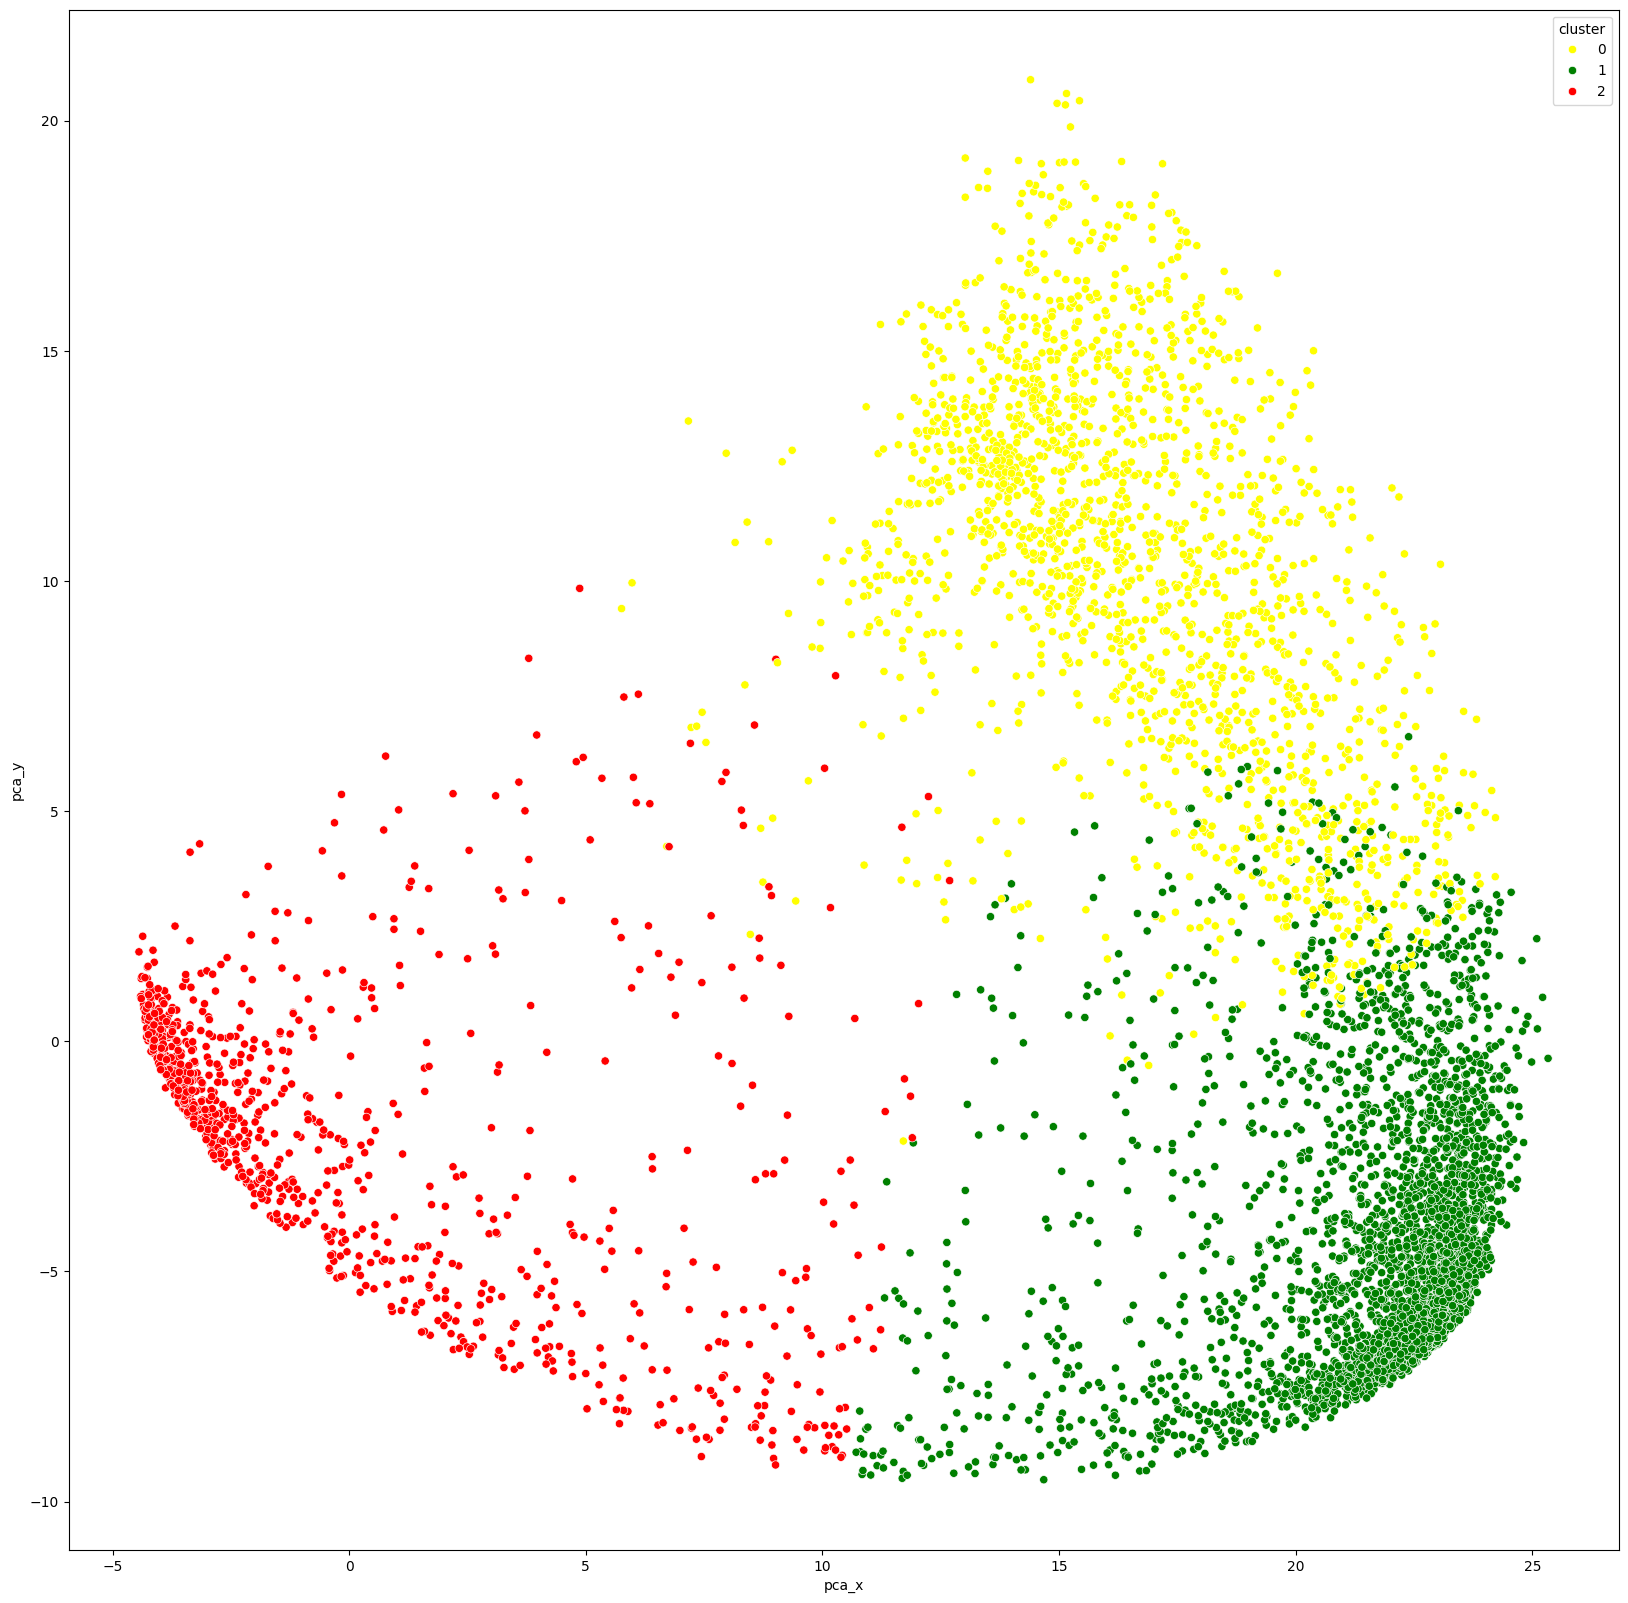

In [ ]:
# Plot the data
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.scatterplot(x='pca_x', y='pca_y', palette={0: '#ffff00', 1: "#008000", 2: '#ff0000'}, hue='cluster', data=df_train_rap)
plt.show()

plt.figure(figsize=(20, 20))
sns.scatterplot(x='pca_x', y='pca_y', palette={0: '#ffff00', 1: "#008000", 2: '#ff0000'}, hue='cluster', data=df_train_metal)
plt.show()

plt.figure(figsize=(20, 20))
sns.scatterplot(x='pca_x', y='pca_y', palette={0: '#ffff00', 1: "#008000", 2: '#ff0000'}, hue='cluster', data=df_train_rock)
plt.show()

plt.figure(figsize=(20, 20))
sns.scatterplot(x='pca_x', y='pca_y', palette={0: '#ffff00', 1: "#008000", 2: '#ff0000'}, hue='cluster', data=df_train_pop)
plt.show()

plt.figure(figsize=(20, 20))
sns.scatterplot(x='pca_x', y='pca_y', palette={0: '#ffff00', 1: "#008000", 2: '#ff0000'}, hue='cluster', data=df_train_rb)
plt.show()